# Get titration curves from Moonshot

In [53]:
submissions_url = 'https://github.com/postera-ai/COVID_moonshot_submissions/blob/master/covid_submissions_all_info.csv?raw=true'
submissions_df = pd.read_csv(submissions_url)

In [281]:
ic50_results = (
    submissions_df
    .query('not @pd.isna(f_curve_IC50)')
    .reset_index()
    .drop('index', axis=1)
)

In [257]:
def process_results(ic50_results, idx=100):
    f_concentration_uM = eval(ic50_results['f_concentration_uM'].iloc[idx])
    f_inhibition_list = eval(ic50_results['f_inhibition_list'].iloc[idx])

    data = []
    for run_idx, _ in enumerate(f_concentration_uM):

        f_conc = f_concentration_uM[run_idx]
        f_inhib = [item['value'] for item in f_inhibition_list[run_idx]]

        concentration_counts = defaultdict(int)
        for j, c in enumerate(f_conc):
            concentration_counts[c] += 1
            run_replicate = f'run={run_idx}, replicate={concentration_counts[c]}'
            data.append(
                {
                    'concentration': c * 1e-6,
                    'run': run_idx,
                    'f_inhibition': f_inhib[j],
                    'replicate': concentration_counts[c],
                    'run_replicate': run_replicate
                }
            )

    data = pd.DataFrame(data)
    return data

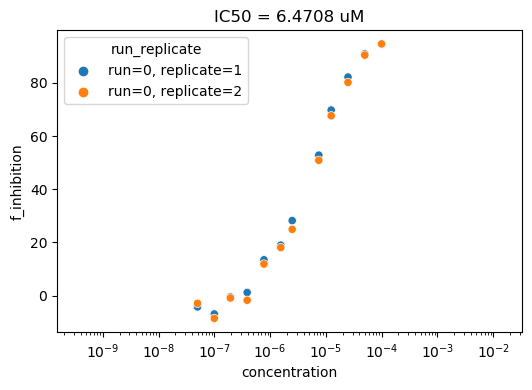

In [365]:
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns

idx = 700 # 1026
data = process_results(ic50_results, idx=idx)

fig, ax = plt.subplots(dpi=100)
ax.set_xscale('log')

sns.scatterplot(
    data=data,
    x='concentration', 
    y='f_inhibition',
    hue='run_replicate',
    ax=ax
)

ic50 = ic50_results.iloc[idx].loc['f_avg_IC50']
ic50 = round(ic50, 4)
ax.set_title(f'IC50 = {ic50} uM')
plt.show()

Text(0.5, 1.0, 'f_avg_pIC50')

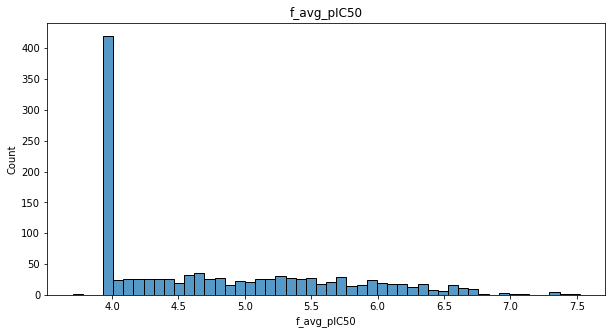

In [362]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(-np.log10(ic50_results['f_avg_IC50'] * 1e-6), ax=ax, bins=50)
ax.set_xlabel('f_avg_pIC50')
ax.set_title('f_avg_pIC50')

Text(0.5, 1.0, 'f_avg_IC50 (uM)')

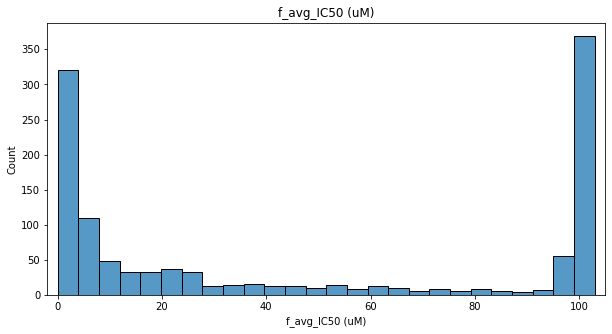

In [361]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(ic50_results['f_avg_IC50'], ax=ax, bins=50)
ax.set_xlim(-2, 105)
ax.set_xlabel('f_avg_IC50 (uM)')
ax.set_title('f_avg_IC50 (uM)')

In [336]:
ic50_results['f_avg_IC50'].dropna()

0       54.272964
1       63.554925
2       26.680129
3       57.469670
4       99.010000
          ...    
1228     0.220345
1229     3.220894
1230    16.908676
1231    99.500000
1232    99.500000
Name: f_avg_IC50, Length: 1206, dtype: float64

## Getting same data from the JSON

In [252]:
import json
import requests

url = 'https://raw.githubusercontent.com/postera-ai/COVID_moonshot_submissions/master/lib/scr/fluorescense_IC50_data.json'
results = requests.get(url).json()

In [253]:
molecules = []
for r in results:
    try:
        mol = r['molecule']
        molecules.append(mol)
    except:
        molecules.append('a')
        pass
molecules = np.array(molecules)

In [293]:
cdd_results = []
for r in results:
    try:
        
        cdd_results.append(
            {
                'concentration_um': r['readouts']['557072'],
                'percent_inhibition': r['readouts']['557073']['value'],
                'mol_id_cdd': r['molecule'],
                'batch': r['batch'],
                'run': r['run']
            }
        )
    except:
        pass
    
cdd_results = pd.DataFrame(cdd_results)
submissions_df['mol_id_cdd'] = submissions_df['CDD_mol_ID']
cdd_results = cdd_results.merge(
    submissions_df[['SMILES', 'mol_id_cdd']],
    how='left',
    on='mol_id_cdd'
)

In [297]:
ic50_results['mol_id_cdd'].iloc[800]

83478864.0

In [301]:
cdd_results.query('mol_id_cdd == 83478864.0')

,concentration_um,percent_inhibition,mol_id_cdd,batch,run,SMILES
17706,0.388,36.054840,83478864,86573411,444063,O=C(Nc1cncc2ccc(F)cc12)C1CCOc2ccc(Cl)cc21
17707,0.388,36.054840,83478864,86573411,444063,O=C(Nc1cncc2ccc(F)cc12)C1CCOc2ccc(Cl)cc21
17727,0.194,24.804659,83478864,86573411,444063,O=C(Nc1cncc2ccc(F)cc12)C1CCOc2ccc(Cl)cc21
17728,0.194,24.804659,83478864,86573411,444063,O=C(Nc1cncc2ccc(F)cc12)C1CCOc2ccc(Cl)cc21
17748,0.100,12.389668,83478864,86573411,444063,O=C(Nc1cncc2ccc(F)cc12)C1CCOc2ccc(Cl)cc21
...,...,...,...,...,...,...
19012,0.100,5.863840,83478864,86573411,444063,O=C(Nc1cncc2ccc(F)cc12)C1CCOc2ccc(Cl)cc21
19030,0.776,55.039066,83478864,86573411,444063,O=C(Nc1cncc2ccc(F)cc12)C1CCOc2ccc(Cl)cc21
19031,0.776,55.039066,83478864,86573411,444063,O=C(Nc1cncc2ccc(F)cc12)C1CCOc2ccc(Cl)cc21
19032,0.050,5.878310,83478864,86573411,444063,O=C(Nc1cncc2ccc(F)cc12)C1CCOc2ccc(Cl)cc21
